## 1. Setup Environment

In [49]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    # Install PyTorch Geometric
    !pip install torch-geometric
    !pip install python-dateutil
else:
    print("Running locally")

Running locally


In [50]:
# Check GPU availability
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device('cpu')
    print("No GPU available, using CPU")

print(f"\nUsing device: {device}")

No GPU available, using CPU

Using device: cpu


In [51]:
# Mount Google Drive (Colab only)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Set paths - MODIFY THESE TO MATCH YOUR DRIVE STRUCTURE
    GRAPH_DIR = '/content/drive/MyDrive/CS224W/graphs'  # Directory containing community folders
else:
    # Local development
    GRAPH_DIR = '../results/graphs'

In [52]:
# Verify data directory exists and list available communities
from pathlib import Path
import os

graph_dir = Path(GRAPH_DIR)

if not graph_dir.exists():
    print(f"ERROR: Graph directory not found: {graph_dir}")
    print("Please update GRAPH_DIR to point to your graphs folder")
else:
    communities = [d.name for d in graph_dir.iterdir() if d.is_dir()]
    print(f"Found {len(communities)} communities:")
    for comm in sorted(communities):
        comm_path = graph_dir / comm
        n_graphs = len(list(comm_path.glob('*.pt')))
        print(f"  - {comm}: {n_graphs} monthly graphs")

Found 47 communities:
  - ai.stackexchange.com: 92 monthly graphs
  - arduino.stackexchange.com: 122 monthly graphs
  - astronomy.stackexchange.com: 127 monthly graphs
  - bioinformatics.stackexchange.com: 83 monthly graphs
  - blender.stackexchange.com: 131 monthly graphs
  - codereview.stackexchange.com: 163 monthly graphs
  - coffee.stackexchange.com: 111 monthly graphs
  - cooking.stackexchange.com: 165 monthly graphs
  - dba.stackexchange.com: 184 monthly graphs
  - devops.stackexchange.com: 86 monthly graphs
  - diy.stackexchange.com: 21 monthly graphs
  - drones.stackexchange.com: 48 monthly graphs
  - english.stackexchange.com: 166 monthly graphs
  - eosio.stackexchange.com: 69 monthly graphs
  - french.stackexchange.com: 152 monthly graphs
  - gardening.stackexchange.com: 159 monthly graphs
  - health.stackexchange.com: 109 monthly graphs
  - iota.stackexchange.com: 72 monthly graphs
  - joomla.stackexchange.com: 120 monthly graphs
  - lifehacks.stackexchange.com: 112 monthly 

## 2. Define Model and Dataset Classes

We define the classes inline to avoid import issues on Colab.

In [53]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import SAGEConv, HeteroConv
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [54]:
class TemporalCommunityGNN(nn.Module):
    """
    Temporal GNN for predicting community health trajectories.
    
    Architecture:
    1. Layer normalization on raw features
    2. Linear projection to shared embedding space
    3. Multiple HeteroConv layers with SAGEConv
    4. ReLU activation + Dropout after each conv
    5. Graph-level pooling (separate for users and tags)
    6. Stack 12 monthly embeddings into temporal sequence
    7. Transformer encoder for temporal modeling
    8. Multi-task prediction heads for 4 engagement metrics
    """
    
    def __init__(
        self,
        user_feat_dim: int,
        tag_feat_dim: int,
        hidden_dim: int = 128,
        num_conv_layers: int = 3,
        num_transformer_layers: int = 3,
        num_attention_heads: int = 4,
        dropout: float = 0.1,
        transformer_ffn_dim: int = 256
    ):
        super(TemporalCommunityGNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_conv_layers = num_conv_layers
        self.dropout = dropout
        
        # Stage 1: Layer Normalization and Feature Projection
        # Note: Using LayerNorm instead of BatchNorm1d because some graphs may have only 1 node
        self.user_norm = nn.LayerNorm(user_feat_dim)
        self.tag_norm = nn.LayerNorm(tag_feat_dim)
        self.user_proj = nn.Linear(user_feat_dim, hidden_dim)
        self.tag_proj = nn.Linear(tag_feat_dim, hidden_dim)
        
        # Stage 2: Graph Convolutional Layers
        self.convs = nn.ModuleList()
        for _ in range(num_conv_layers):
            conv = HeteroConv({
                ("tag", "cooccurs", "tag"): SAGEConv(hidden_dim, hidden_dim, aggr="mean"),
                ("user", "contributes", "tag"): SAGEConv((hidden_dim, hidden_dim), hidden_dim, aggr="mean"),
                ("tag", "contributed_to_by", "user"): SAGEConv((hidden_dim, hidden_dim), hidden_dim, aggr="mean"),
            }, aggr="mean")
            self.convs.append(conv)
        
        self.conv_dropout = nn.Dropout(dropout)
        
        # Stage 3: Temporal Modeling with Transformer
        community_emb_dim = 2 * hidden_dim
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=community_emb_dim,
            nhead=num_attention_heads,
            dim_feedforward=transformer_ffn_dim,
            dropout=dropout,
            batch_first=True
        )
        self.temporal_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        
        # Stage 4: Multi-task Prediction Heads
        self.qpd_head = nn.Linear(community_emb_dim, 1)
        self.ansrate_head = nn.Linear(community_emb_dim, 1)

        self.growth_head = nn.Linear(community_emb_dim, 1)
    
    def project_features(self, x_dict):
        """Apply batch normalization and project to shared embedding space."""
        x_dict_projected = {}
        if "user" in x_dict:
            x_user = x_dict["user"]
            x_user = self.user_norm(x_user)
            x_dict_projected["user"] = self.user_proj(x_user)
        if "tag" in x_dict:
            x_tag = x_dict["tag"]
            x_tag = self.tag_norm(x_tag)
            x_dict_projected["tag"] = self.tag_proj(x_tag)
        return x_dict_projected
    
    def apply_conv_layers(self, x_dict, edge_index_dict):
        """Apply graph convolutional layers with ReLU and dropout."""
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: torch.relu(x) for key, x in x_dict.items()}
            x_dict = {key: self.conv_dropout(x) for key, x in x_dict.items()}
        return x_dict
    
    def pool_graph(self, x_dict):
        """Pool node embeddings to create community-level representation."""
        user_pooled = x_dict["user"].mean(dim=0)
        tag_pooled = x_dict["tag"].mean(dim=0)
        community_emb = torch.cat([user_pooled, tag_pooled])
        return community_emb
    
    def forward_single_graph(self, x_dict, edge_index_dict):
        """Forward pass for a single monthly graph."""
        x_dict = self.project_features(x_dict)
        x_dict = self.apply_conv_layers(x_dict, edge_index_dict)
        community_emb = self.pool_graph(x_dict)
        return community_emb
    
    def forward_temporal_sequence(self, monthly_embeddings):
        """Apply temporal modeling with Transformer."""
        temporal_out = self.temporal_encoder(monthly_embeddings)
        final_repr = temporal_out[:, -1, :]
        return final_repr
    
    def predict_metrics(self, temporal_repr):
        """Multi-task prediction of engagement metrics."""
        predictions = {
            "qpd": self.qpd_head(temporal_repr).squeeze(-1),
            "answer_rate": self.ansrate_head(temporal_repr).squeeze(-1),
            "growth": self.growth_head(temporal_repr).squeeze(-1)
        }
        return predictions
    
    def forward(self, batch_monthly_graphs):
        """
        Forward pass for batched temporal sequences.
        
        Args:
            batch_monthly_graphs: List of lists [batch_size][12 monthly graphs]
        """
        batch_temporal_embeddings = []
        
        for community_graphs in batch_monthly_graphs:
            monthly_embeddings = []
            for graph in community_graphs:
                if isinstance(graph, tuple):
                    x_dict, edge_index_dict = graph
                else:
                    x_dict = graph.x_dict
                    edge_index_dict = graph.edge_index_dict
                community_emb = self.forward_single_graph(x_dict, edge_index_dict)
                monthly_embeddings.append(community_emb)
            community_temporal_emb = torch.stack(monthly_embeddings)
            batch_temporal_embeddings.append(community_temporal_emb)
        
        batch_temporal_embeddings = torch.stack(batch_temporal_embeddings)
        temporal_repr = self.forward_temporal_sequence(batch_temporal_embeddings)
        predictions = self.predict_metrics(temporal_repr)
        return predictions

In [55]:
class TemporalCommunityDataset(Dataset):
    """
    Dataset for temporal community health prediction.
    
    Each sample consists of:
    - 12 monthly graphs (t-11 to t) as input sequence
    - Target metrics from graph at t+6 (6 months ahead)
    """
    
    def __init__(
        self,
        graph_dir: Path,
        split: str = 'train',
        sequence_length: int = 12,
        prediction_horizon: int = 6,
        min_graphs_required: int = None,
        communities: List[str] = None
    ):
        self.graph_dir = Path(graph_dir)
        self.split = split
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.min_graphs_required = min_graphs_required or (sequence_length + prediction_horizon)
        self.communities = communities  # Optional list of communities to include
        
        # Temporal splits
        self.split_ranges = {
            'train': ('2008-01', '2020-06'),
            'val': ('2020-07', '2022-09'),
            'test': ('2022-10', '2023-09')
        }
        
        self.samples = self._build_sample_index()
        
        print(f"\n{split.upper()} Dataset:")
        print(f"  Date range: {self.split_ranges[split][0]} to {self.split_ranges[split][1]}")
        print(f"  Total samples: {len(self.samples)}")
        if self.samples:
            communities = set(s['community'] for s in self.samples)
            print(f"  Communities: {len(communities)}")
    
    def _build_sample_index(self) -> List[Dict]:
        """Build index of all valid (community, month) samples for this split."""
        samples = []
        start_month, end_month = self.split_ranges[self.split]
        
        for community_dir in sorted(self.graph_dir.iterdir()):
            if not community_dir.is_dir():
                continue
            
            community_name = community_dir.name
            
            # Skip if communities filter is set and this community is not in the list
            if self.communities is not None and community_name not in self.communities:
                continue
            available_months = sorted([f.stem for f in community_dir.glob('*.pt')])
            
            if len(available_months) < self.min_graphs_required:
                continue
            
            for i, month_t in enumerate(available_months):
                if not (start_month <= month_t <= end_month):
                    continue
                if i < self.sequence_length - 1:
                    continue
                
                target_idx = i + self.prediction_horizon
                if target_idx >= len(available_months):
                    continue
                
                sequence_start_idx = i - self.sequence_length + 1
                sequence_months = available_months[sequence_start_idx : i + 1]
                target_month = available_months[target_idx]
                
                if self._is_consecutive_sequence(sequence_months, target_month):
                    samples.append({
                        'community': community_name,
                        'sequence_months': sequence_months,
                        'target_month': target_month,
                        'end_month': month_t
                    })
        
        return samples
    
    def _is_consecutive_sequence(self, sequence_months: List[str], target_month: str) -> bool:
        """Verify months form a consecutive sequence."""
        try:
            if len(sequence_months) != self.sequence_length:
                return False
            
            for i in range(len(sequence_months) - 1):
                curr = datetime.strptime(sequence_months[i], '%Y-%m')
                next_month = datetime.strptime(sequence_months[i + 1], '%Y-%m')
                expected_next = curr + relativedelta(months=1)
                if next_month != expected_next:
                    return False
            
            last_month = datetime.strptime(sequence_months[-1], '%Y-%m')
            target = datetime.strptime(target_month, '%Y-%m')
            expected_target = last_month + relativedelta(months=self.prediction_horizon)
            return target == expected_target
            
        except (ValueError, IndexError):
            return False
    
    def get_sample_info(self, idx: int) -> Dict:
        """Get information about a sample without loading the graphs."""
        return self.samples[idx].copy()
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[List, Dict[str, float]]:
        """Load a single sample."""
        sample = self.samples[idx]
        community_dir = self.graph_dir / sample['community']
        
        graphs = []
        for month in sample['sequence_months']:
            graph_path = community_dir / f"{month}.pt"
            graph = torch.load(graph_path, weights_only=False)
            graphs.append(graph)
        
        target_path = community_dir / f"{sample['target_month']}.pt"
        target_graph = torch.load(target_path, weights_only=False)
        targets = target_graph.y
        
        return graphs, targets


def collate_temporal_batch(batch: List[Tuple]) -> Tuple[List[List], Dict[str, torch.Tensor]]:
    """Collate function for batching temporal graph sequences."""
    batch_graphs = []
    batch_targets = {'qpd': [], 'answer_rate': [], 'growth': []}
    
    for graphs, targets in batch:
        batch_graphs.append(graphs)
        for key in batch_targets.keys():
            batch_targets[key].append(targets[key])
    
    for key in batch_targets.keys():
        batch_targets[key] = torch.tensor(batch_targets[key], dtype=torch.float32)
    
    return batch_graphs, batch_targets

## 3. Load Data

Plotting metrics for community: ai.stackexchange.com


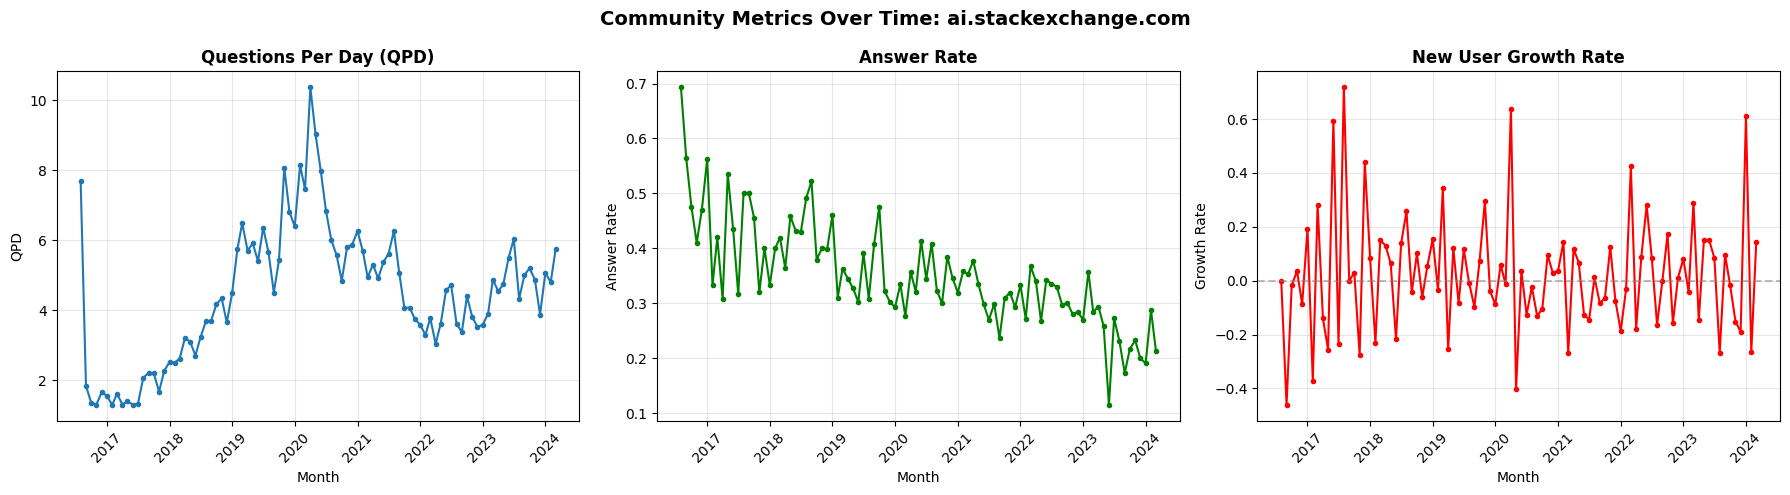


METRIC STATISTICS for ai.stackexchange.com

QPD:
  Mean: 4.4195
  Std:  1.8994
  Min:  1.2857
  Max:  10.3667
  Range: 9.0810

ANSWER_RATE:
  Mean: 0.3509
  Std:  0.0930
  Min:  0.1152
  Max:  0.6933
  Range: 0.5781

GROWTH:
  Mean: 0.0221
  Std:  0.2167
  Min:  -0.4615
  Max:  0.7179
  Range: 1.1795
  ⚠️  High variability detected (std > 50% of mean)

Total months: 92
Date range: 2016-08 to 2024-03


In [56]:
# Plot metrics over time for a sample community
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import numpy as np

# Ensure graph_dir and communities are defined (from cell 4)
if 'graph_dir' not in globals():
    graph_dir = Path(GRAPH_DIR)
if 'communities' not in globals():
    communities = [d.name for d in graph_dir.iterdir() if d.is_dir()]

# Pick a sample community (use the first one with good data)
sample_community = sorted(communities)[0]  # e.g., 'english.stackexchange.com'
print(f"Plotting metrics for community: {sample_community}")

# Load all graphs for this community
community_dir = graph_dir / sample_community
graph_files = sorted(community_dir.glob('*.pt'))

if len(graph_files) == 0:
    print(f"No graph files found for {sample_community}")
else:
    # Extract metrics for each month
    months = []
    metrics = {
        'qpd': [],
        'answer_rate': [],

        'growth': []
    }
    
    for graph_file in graph_files:
        try:
            graph = torch.load(graph_file, weights_only=False)
            month = graph_file.stem  # e.g., '2010-08'
            
            if hasattr(graph, 'y') and graph.y is not None:
                months.append(month)
                for key in metrics.keys():
                    if key in graph.y:
                        metrics[key].append(graph.y[key])
                    else:
                        metrics[key].append(np.nan)
        except Exception as e:
            print(f"Error loading {graph_file.name}: {e}")
            continue
    
    if len(months) > 0:
        # Convert months to datetime for better plotting
        month_dates = [datetime.strptime(m, '%Y-%m') for m in months]
        
        # Create subplots for each metric
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'Community Metrics Over Time: {sample_community}', fontsize=14, fontweight='bold')
        
        # Plot QPD (Questions Per Day)
        ax = axes[0]
        ax.plot(month_dates, metrics['qpd'], marker='o', markersize=3, linewidth=1.5)
        ax.set_title('Questions Per Day (QPD)', fontweight='bold')
        ax.set_xlabel('Month')
        ax.set_ylabel('QPD')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Plot Answer Rate
        ax = axes[1]
        ax.plot(month_dates, metrics['answer_rate'], marker='o', markersize=3, linewidth=1.5, color='green')
        ax.set_title('Answer Rate', fontweight='bold')
        ax.set_xlabel('Month')
        ax.set_ylabel('Answer Rate')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Plot Growth
        ax = axes[2]
        ax.plot(month_dates, metrics['growth'], marker='o', markersize=3, linewidth=1.5, color='red')
        ax.set_title('New User Growth Rate', fontweight='bold')
        ax.set_xlabel('Month')
        ax.set_ylabel('Growth Rate')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\n{'='*60}")
        print(f"METRIC STATISTICS for {sample_community}")
        print(f"{'='*60}")
        for key in metrics.keys():
            values = np.array(metrics[key])
            valid_values = values[~np.isnan(values)]
            if len(valid_values) > 0:
                print(f"\n{key.upper()}:")
                print(f"  Mean: {np.mean(valid_values):.4f}")
                print(f"  Std:  {np.std(valid_values):.4f}")
                print(f"  Min:  {np.min(valid_values):.4f}")
                print(f"  Max:  {np.max(valid_values):.4f}")
                print(f"  Range: {np.max(valid_values) - np.min(valid_values):.4f}")
                # Check for extreme variations
                if np.std(valid_values) > np.abs(np.mean(valid_values)) * 0.5:
                    print(f"  ⚠️  High variability detected (std > 50% of mean)")
            else:
                print(f"\n{key.upper()}: No valid data")
        
        print(f"\n{'='*60}")
        print(f"Total months: {len(months)}")
        print(f"Date range: {months[0]} to {months[-1]}")
        print(f"{'='*60}")
    else:
        print("No valid metrics found in graphs")

In [57]:
# Create datasets for train/val/test
print("Loading datasets...")

# Limit to 3 communities for faster training
SELECTED_COMMUNITIES = [
    'stats.stackexchange.com',
    'english.stackexchange.com', 
    'cooking.stackexchange.com'
]

train_dataset = TemporalCommunityDataset(graph_dir=GRAPH_DIR, split='train', communities=SELECTED_COMMUNITIES)
val_dataset = TemporalCommunityDataset(graph_dir=GRAPH_DIR, split='val', communities=SELECTED_COMMUNITIES)
test_dataset = TemporalCommunityDataset(graph_dir=GRAPH_DIR, split='test', communities=SELECTED_COMMUNITIES)

Loading datasets...

TRAIN Dataset:
  Date range: 2008-01 to 2020-06
  Total samples: 326
  Communities: 3

VAL Dataset:
  Date range: 2020-07 to 2022-09
  Total samples: 81
  Communities: 3

TEST Dataset:
  Date range: 2022-10 to 2023-09
  Total samples: 36
  Communities: 3


In [58]:
# Inspect a sample to understand graph structure
if len(train_dataset) > 0:
    sample_graphs, sample_targets = train_dataset[0]
    sample_info = train_dataset.get_sample_info(0)
    
    print(f"\nSample Information:")
    print(f"  Community: {sample_info['community']}")
    print(f"  Sequence: {sample_info['sequence_months'][0]} to {sample_info['sequence_months'][-1]}")
    print(f"  Target month: {sample_info['target_month']}")
    
    print(f"\nGraph Structure (first month):")
    g = sample_graphs[0]
    print(f"  Users: {g['user'].x.shape[0]} nodes, {g['user'].x.shape[1]} features")
    print(f"  Tags: {g['tag'].x.shape[0]} nodes, {g['tag'].x.shape[1]} features")
    
    if ('tag', 'cooccurs', 'tag') in g.edge_index_dict:
        print(f"  Tag-Tag edges: {g['tag', 'cooccurs', 'tag'].edge_index.shape[1]}")
    if ('user', 'contributes', 'tag') in g.edge_index_dict:
        print(f"  User-Tag edges: {g['user', 'contributes', 'tag'].edge_index.shape[1]}")
    
    print(f"\nTargets:")
    for key, val in sample_targets.items():
        print(f"  {key}: {val:.4f}")
    
    # Get feature dimensions
    USER_FEAT_DIM = g['user'].x.shape[1]
    TAG_FEAT_DIM = g['tag'].x.shape[1]
    print(f"\nFeature dimensions: user={USER_FEAT_DIM}, tag={TAG_FEAT_DIM}")
else:
    print("No training samples found!")
    USER_FEAT_DIM = 5  # Default based on code
    TAG_FEAT_DIM = 7


Sample Information:
  Community: cooking.stackexchange.com
  Sequence: 2010-07 to 2011-06
  Target month: 2011-12

Graph Structure (first month):
  Users: 516 nodes, 5 features
  Tags: 416 nodes, 7 features
  Tag-Tag edges: 2548
  User-Tag edges: 6071

Targets:
  qpd: 7.6452
  answer_rate: 0.6118
  retention: 0.0000
  growth: 0.3182

Feature dimensions: user=5, tag=7


In [59]:
# Create dataloaders
BATCH_SIZE = 4  # Start small to test memory usage

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_temporal_batch,
    num_workers=0  # Use 0 for Colab compatibility
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_temporal_batch,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_temporal_batch,
    num_workers=0
)

print(f"\nDataLoaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")


DataLoaders created:
  Train: 82 batches
  Val: 21 batches
  Test: 9 batches


## 4. Create Model

In [60]:
# Model hyperparameters
HIDDEN_DIM = 128
NUM_CONV_LAYERS = 3
NUM_TRANSFORMER_LAYERS = 3
NUM_ATTENTION_HEADS = 4
DROPOUT = 0.1
TRANSFORMER_FFN_DIM = 256

# Create model
model = TemporalCommunityGNN(
    user_feat_dim=USER_FEAT_DIM,
    tag_feat_dim=TAG_FEAT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_conv_layers=NUM_CONV_LAYERS,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
    num_attention_heads=NUM_ATTENTION_HEADS,
    dropout=DROPOUT,
    transformer_ffn_dim=TRANSFORMER_FFN_DIM
)

model = model.to(device)

print(f"Model Architecture:")
print(f"  User features: {USER_FEAT_DIM} -> Embedding: {HIDDEN_DIM}")
print(f"  Tag features: {TAG_FEAT_DIM} -> Embedding: {HIDDEN_DIM}")
print(f"  Graph conv layers: {NUM_CONV_LAYERS}")
print(f"  Transformer layers: {NUM_TRANSFORMER_LAYERS} ({NUM_ATTENTION_HEADS} attention heads)")
print(f"  Community embedding: {2 * HIDDEN_DIM}")
print(f"  Output: 3 metrics (QPD, Answer Rate, Growth)")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
  User features: 5 -> Embedding: 128
  Tag features: 7 -> Embedding: 128
  Graph conv layers: 3
  Transformer layers: 3 (4 attention heads)
  Community embedding: 256
  Output: 3 metrics (QPD, Answer Rate, Growth)

Total parameters: 1,485,979
Trainable parameters: 1,485,979


## 5. Training Setup

In [61]:
# Training hyperparameters
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 5  # Reduced for faster iteration

# Loss weights for multi-task learning (can be tuned)
LOSS_WEIGHTS = {
    'qpd': 1.0,
    'answer_rate': 1.0,
    'growth': 1.0
}

# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.MSELoss()

In [62]:
def move_graphs_to_device(batch_graphs, device):
    """Move all graphs in batch to specified device."""
    batch_on_device = []
    for community_graphs in batch_graphs:
        graphs_on_device = []
        for g in community_graphs:
            g = g.to(device)
            graphs_on_device.append(g)
        batch_on_device.append(graphs_on_device)
    return batch_on_device


def compute_multi_task_loss(predictions, targets, weights, criterion):
    """Compute weighted multi-task loss."""
    total_loss = 0.0
    losses = {}
    
    for key in predictions.keys():
        loss = criterion(predictions[key], targets[key].to(predictions[key].device))
        weighted_loss = weights[key] * loss
        total_loss += weighted_loss
        losses[key] = loss.item()
    
    return total_loss, losses


def train_epoch(model, loader, optimizer, criterion, loss_weights, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    task_losses = {'qpd': 0.0, 'answer_rate': 0.0, 'growth': 0.0}
    n_batches = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch_graphs, batch_targets in pbar:
        # Move to device
        batch_graphs = move_graphs_to_device(batch_graphs, device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(batch_graphs)
        
        # Compute loss
        loss, losses = compute_multi_task_loss(predictions, batch_targets, loss_weights, criterion)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Track losses
        total_loss += loss.item()
        for key in task_losses:
            task_losses[key] += losses[key]
        n_batches += 1
        
        pbar.set_postfix({'loss': loss.item()})
    
    # Average losses
    avg_loss = total_loss / n_batches if n_batches > 0 else 0.0
    avg_task_losses = {k: v / n_batches if n_batches > 0 else 0.0 for k, v in task_losses.items()}
    
    return avg_loss, avg_task_losses


@torch.no_grad()
def evaluate(model, loader, criterion, loss_weights, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0.0
    task_losses = {'qpd': 0.0, 'answer_rate': 0.0, 'growth': 0.0}
    n_batches = 0
    
    all_predictions = {'qpd': [], 'answer_rate': [], 'growth': []}
    all_targets = {'qpd': [], 'answer_rate': [], 'growth': []}
    
    for batch_graphs, batch_targets in tqdm(loader, desc='Evaluating', leave=False):
        batch_graphs = move_graphs_to_device(batch_graphs, device)
        predictions = model(batch_graphs)
        
        loss, losses = compute_multi_task_loss(predictions, batch_targets, loss_weights, criterion)
        
        total_loss += loss.item()
        for key in task_losses:
            task_losses[key] += losses[key]
            all_predictions[key].extend(predictions[key].cpu().numpy())
            all_targets[key].extend(batch_targets[key].numpy())
        n_batches += 1
    
    avg_loss = total_loss / n_batches if n_batches > 0 else 0.0
    avg_task_losses = {k: v / n_batches if n_batches > 0 else 0.0 for k, v in task_losses.items()}
    
    # Compute R² for each task
    r2_scores = {}
    for key in all_predictions:
        preds = np.array(all_predictions[key])
        targets = np.array(all_targets[key])
        if len(preds) > 0:
            ss_res = np.sum((targets - preds) ** 2)
            ss_tot = np.sum((targets - np.mean(targets)) ** 2)
            r2_scores[key] = 1 - (ss_res / (ss_tot + 1e-8))
        else:
            r2_scores[key] = 0.0
    
    return avg_loss, avg_task_losses, r2_scores

## 6. Train Model

In [63]:
# Training loop
print("Starting training...")
print(f"Device: {device}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print()

history = {
    'train_loss': [],
    'val_loss': [],
    'train_task_losses': [],
    'val_task_losses': [],
    'val_r2': []
}

best_val_loss = float('inf')
best_model_state = None

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_task_losses = train_epoch(
        model, train_loader, optimizer, criterion, LOSS_WEIGHTS, device
    )
    
    # Validate
    val_loss, val_task_losses, val_r2 = evaluate(
        model, val_loader, criterion, LOSS_WEIGHTS, device
    )
    
    # Update scheduler
    scheduler.step()
    
    # Track history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_task_losses'].append(train_task_losses)
    history['val_task_losses'].append(val_task_losses)
    history['val_r2'].append(val_r2)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val R²: QPD={val_r2['qpd']:.3f}, Ans={val_r2['answer_rate']:.3f}, "
          f"Grw={val_r2['growth']:.3f}")

print(f"\nBest validation loss: {best_val_loss:.4f}")

Starting training...
Device: cpu
Epochs: 5
Batch size: 4
Learning rate: 0.0001



Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch   1/5 | Train Loss: 782.4330 | Val Loss: 417.5382 | Val R²: QPD=-0.254, Ans=-0.278, Grw=-0.509


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch   2/5 | Train Loss: 656.8758 | Val Loss: 384.6050 | Val R²: QPD=-0.159, Ans=-0.999, Grw=-1.854


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch   3/5 | Train Loss: 611.5330 | Val Loss: 366.3925 | Val R²: QPD=-0.108, Ans=-7.498, Grw=-0.057


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch   4/5 | Train Loss: 584.1783 | Val Loss: 350.8194 | Val R²: QPD=-0.061, Ans=-4.912, Grw=-1.247


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch   5/5 | Train Loss: 554.8053 | Val Loss: 329.4742 | Val R²: QPD=0.008, Ans=-13.472, Grw=-2.154

Best validation loss: 329.4742


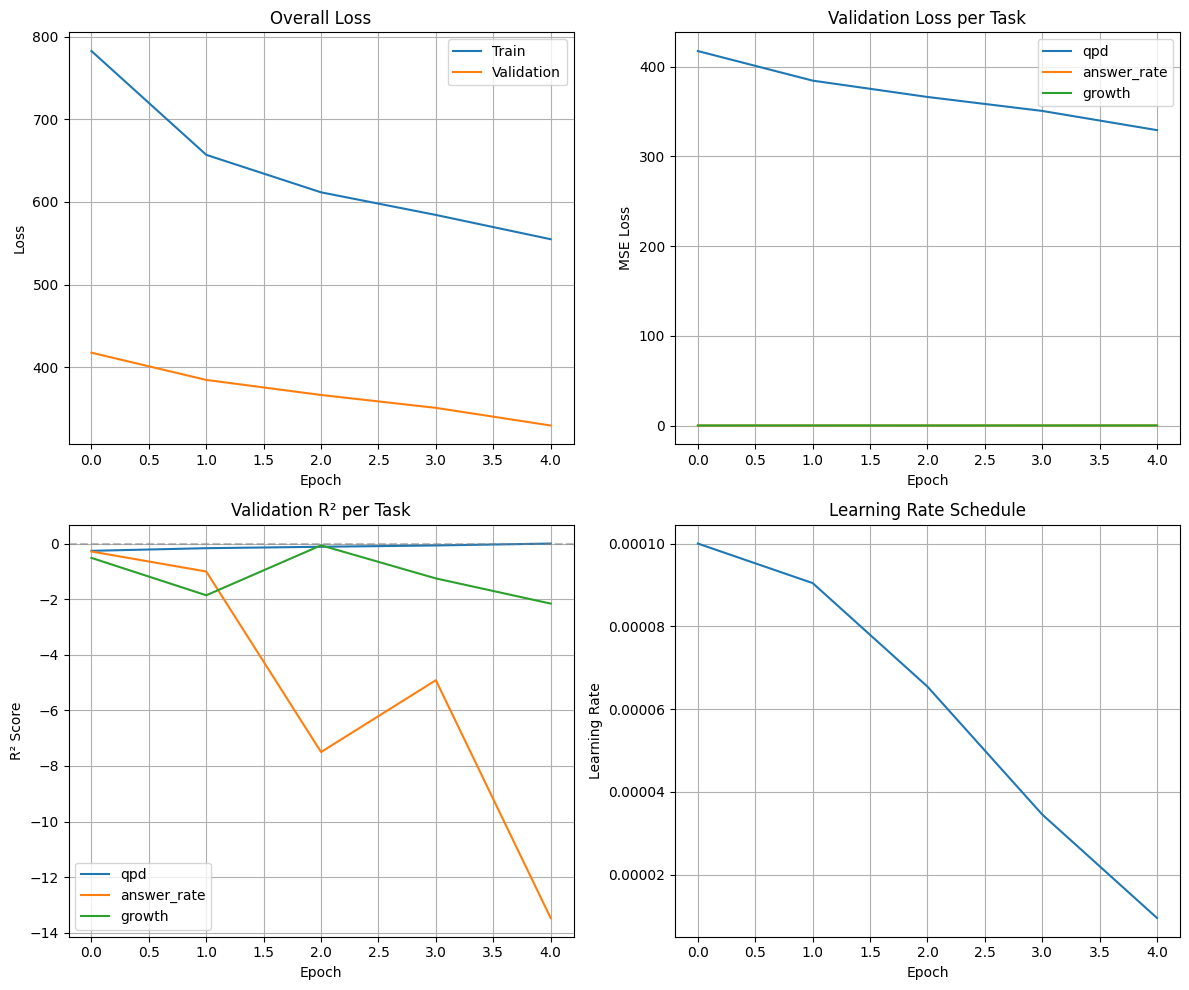

In [64]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Overall loss
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train')
ax.plot(history['val_loss'], label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Overall Loss')
ax.legend()
ax.grid(True)

# Per-task validation loss
ax = axes[0, 1]
for key in ['qpd', 'answer_rate', 'growth']:
    task_losses = [h[key] for h in history['val_task_losses']]
    ax.plot(task_losses, label=key)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Validation Loss per Task')
ax.legend()
ax.grid(True)

# R² scores
ax = axes[1, 0]
for key in ['qpd', 'answer_rate', 'growth']:
    r2_scores = [h[key] for h in history['val_r2']]
    ax.plot(r2_scores, label=key)
ax.set_xlabel('Epoch')
ax.set_ylabel('R² Score')
ax.set_title('Validation R² per Task')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True)

# Learning rate
ax = axes[1, 1]
lrs = [LEARNING_RATE * np.cos(np.pi * i / NUM_EPOCHS) / 2 + LEARNING_RATE / 2 for i in range(NUM_EPOCHS)]
ax.plot(lrs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluate on Test Set

In [65]:
# Load best model and evaluate on test set
if best_model_state is not None:
    model.load_state_dict(best_model_state)

test_loss, test_task_losses, test_r2 = evaluate(
    model, test_loader, criterion, LOSS_WEIGHTS, device
)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"\nOverall Test Loss: {test_loss:.4f}")
print(f"\nPer-task MSE Loss:")
for key, loss in test_task_losses.items():
    print(f"  {key:15s}: {loss:.4f}")

print(f"\nPer-task R² Score:")
for key, r2 in test_r2.items():
    print(f"  {key:15s}: {r2:.4f}")

print("\n" + "=" * 60)

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

TEST SET RESULTS

Overall Test Loss: 247.4089

Per-task MSE Loss:
  qpd            : 247.2584
  answer_rate    : 0.0587
  growth         : 0.0918

Per-task R² Score:
  qpd            : 0.0722
  answer_rate    : -9.5945
  growth         : -2.8565



## 8. Save Model

In [ ]:
# Save the trained model
if IN_COLAB:
    save_path = '/content/drive/MyDrive/CS224W/models/temporal_gnn_best.pt'
else:
    save_path = '../results/models/temporal_gnn_best.pt'

save_dir = Path(save_path).parent
save_dir.mkdir(parents=True, exist_ok=True)

checkpoint = {
    'model_state_dict': best_model_state,
    'hyperparameters': {
        'user_feat_dim': USER_FEAT_DIM,
        'tag_feat_dim': TAG_FEAT_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_conv_layers': NUM_CONV_LAYERS,
        'num_transformer_layers': NUM_TRANSFORMER_LAYERS,
        'num_attention_heads': NUM_ATTENTION_HEADS,
        'dropout': DROPOUT,
        'transformer_ffn_dim': TRANSFORMER_FFN_DIM
    },
    'training_history': history,
    'test_results': {
        'loss': test_loss,
        'task_losses': test_task_losses,
        'r2_scores': test_r2
    }
}

torch.save(checkpoint, save_path)
print(f"Model saved to: {save_path}")

## 9. Memory and Compute Profiling

In [66]:
# Profile memory and compute requirements
print("=" * 60)
print("RESOURCE PROFILING")
print("=" * 60)

# Model size
model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / 1024 / 1024
print(f"\nModel size: {model_size_mb:.2f} MB")

# GPU memory (if available)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    
    # Run a forward pass to measure peak memory
    if len(train_loader) > 0:
        batch_graphs, batch_targets = next(iter(train_loader))
        batch_graphs = move_graphs_to_device(batch_graphs, device)
        
        model.train()
        predictions = model(batch_graphs)
        loss, _ = compute_multi_task_loss(predictions, batch_targets, LOSS_WEIGHTS, criterion)
        loss.backward()
        
        peak_memory_mb = torch.cuda.max_memory_allocated() / 1024 / 1024
        print(f"Peak GPU memory (batch_size={BATCH_SIZE}): {peak_memory_mb:.2f} MB")
        
        # Estimate memory for larger batch sizes
        print(f"\nEstimated GPU memory for different batch sizes:")
        for bs in [1, 2, 4, 8, 16]:
            est_memory = peak_memory_mb * (bs / BATCH_SIZE)
            print(f"  Batch size {bs:2d}: ~{est_memory:.0f} MB")

# Dataset statistics
print(f"\nDataset statistics:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

# Time per epoch estimate
import time
if len(train_loader) > 0:
    start = time.time()
    _ = train_epoch(model, train_loader, optimizer, criterion, LOSS_WEIGHTS, device)
    epoch_time = time.time() - start
    print(f"\nTime per epoch: {epoch_time:.1f} seconds")
    print(f"Estimated total training time ({NUM_EPOCHS} epochs): {epoch_time * NUM_EPOCHS / 60:.1f} minutes")

RESOURCE PROFILING

Model size: 5.67 MB

Dataset statistics:
  Train samples: 326
  Val samples: 81
  Test samples: 36
  Total samples: 443


Training:   0%|          | 0/82 [00:00<?, ?it/s]


Time per epoch: 122.8 seconds
Estimated total training time (5 epochs): 10.2 minutes


## Notes for Colab Usage

### GPU Selection
- Go to **Runtime > Change runtime type > Hardware accelerator > GPU**
- T4 GPU (free tier) should be sufficient for this model
- For faster training, use A100 or V100 (requires Colab Pro)

### Memory Considerations
- Batch size of 4-8 should work on T4 GPU (15GB)
- If OOM errors occur, reduce batch size
- Each sample loads 12 graphs + 1 target graph

### Colab Credits
- Free tier: ~4 hours continuous GPU usage
- Pro tier: ~24 hours, priority access to faster GPUs
- Training ~50 epochs on 2 communities should complete within free tier limits